Policy iteration 0...
Policy iteration 1...
Policy iteration 2...
Policy iteration 3...
Policy iteration converged at iteration 3.
Final cost-to-go V (first 10 states): [1887.80799896 1880.82799896 1874.3934535  1868.50436259 1863.16072623
 1858.36254441 1854.10981714 1850.40254441 1847.24072623 1844.62436259]
Final policy (first 10 states): [199 199 199 199 199 199 199 199 199 199]
Inventory = 0, best action = 9
Inventory = 1, best action = 8
Inventory = 2, best action = 7
Inventory = 3, best action = 6
Inventory = 4, best action = 5
Inventory = 5, best action = 4


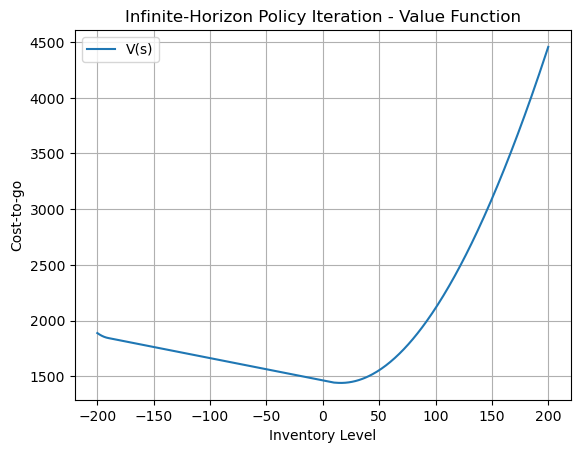

In [9]:
import numpy as np
import matplotlib.pyplot as plt

class InfiniteHorizonPolicyIteration:
    def __init__(self, 
                 min_inventory, 
                 max_inventory, 
                 num_actions, 
                 discount,
                 p,      # Procurement cost per unit
                 a_cost, # Holding cost coefficient
                 b_cost, # Backlog cost coefficient
                 demand_max):
        """
        Initialize parameters for infinite-horizon inventory control.
        
        State space: inventory in [min_inventory..max_inventory].
        Actions: discrete order quantities in [0..num_actions-1].
        Demand: uniform over {0,...,demand_max}.
        discount in (0,1] for cost minimization.
        """
        self.min_inventory = min_inventory
        self.max_inventory = max_inventory
        self.num_states = max_inventory - min_inventory + 1
        self.num_actions = num_actions
        self.discount = discount
        
        self.p = p
        self.a_cost = a_cost
        self.b_cost = b_cost
        self.demand_max = demand_max
        self.demand_prob = 1.0 / (demand_max + 1)
        
        # Initialize policy arbitrarily: e.g., order 0 for all states.
        self.policy = np.zeros(self.num_states, dtype=int)
        # Initialize value function to zeros
        self.V = np.zeros(self.num_states)
    
    def state_to_inv(self, s_idx):
        return s_idx + self.min_inventory
    
    def inv_to_state(self, inv):
        return max(0, min(inv - self.min_inventory, self.num_states - 1))
    
    def immediate_cost(self, inv, action):
        """
        Immediate ordering cost if you order 'action' units from inventory 'inv'.
        We'll add holding/backlog cost after demand in the transitions.
        """
        return self.p * action
    
    def holding_backlog_cost(self, inv):
        """Holding/backlog cost for an inventory level inv."""
        if inv >= 0:
            return self.a_cost * inv
        else:
            return self.b_cost * (-inv)
    
    def one_step_cost(self, inv, action, next_inv):
        """
        Full immediate cost: ordering cost + holding/backlog for next_inv.
        """
        return self.immediate_cost(inv, action) + self.holding_backlog_cost(next_inv)
    
    def policy_evaluation(self, policy, max_eval_iter=1000, eval_epsilon=1e-6):
        """
        Given a stationary policy (1D array: policy[state] -> action),
        compute the cost-to-go V^policy by iterative evaluation.
        
        We'll do a Bellman backup for the *fixed* policy until convergence:
          V_{new}(s) = sum_{w} prob(w) [ one_step_cost(s, policy[s], s') + discount*V_{old}(s') ],
          where s' = s + policy[s] - w, clamped.
        """
        for _ in range(max_eval_iter):
            V_new = np.zeros_like(self.V)
            for s_idx in range(self.num_states):
                inv = self.state_to_inv(s_idx)
                action = policy[s_idx]
                cost_sum = 0.0
                for w in range(self.demand_max + 1):
                    prob_w = self.demand_prob
                    next_inv = inv + action - w
                    # clamp
                    next_inv = max(self.min_inventory, min(next_inv, self.max_inventory))
                    next_s_idx = self.inv_to_state(next_inv)
                    cost_immediate = self.one_step_cost(inv, action, next_inv)
                    cost_sum += prob_w * (cost_immediate + self.discount * self.V[next_s_idx])
                V_new[s_idx] = cost_sum
            diff = np.max(np.abs(V_new - self.V))
            self.V = V_new
            if diff < eval_epsilon:
                break
    
    def policy_improvement(self):
        """
        Greedily improve the policy using the current V.
        For each state s, pick the action a that minimizes
          Q(s,a) = sum_w prob(w)*[one_step_cost(s,a,s') + discount*V(s')],
        where s' is the next state.
        
        Returns: a new policy array, and a boolean indicating if policy changed.
        """
        policy_stable = True
        new_policy = np.copy(self.policy)
        for s_idx in range(self.num_states):
            inv = self.state_to_inv(s_idx)
            best_action = new_policy[s_idx]
            best_value = None
            for a in range(self.num_actions):
                cost_sum = 0.0
                for w in range(self.demand_max + 1):
                    prob_w = self.demand_prob
                    next_inv = inv + a - w
                    next_inv = max(self.min_inventory, min(next_inv, self.max_inventory))
                    next_s_idx = self.inv_to_state(next_inv)
                    cost_immediate = self.one_step_cost(inv, a, next_inv)
                    cost_sum += prob_w * (cost_immediate + self.discount * self.V[next_s_idx])
                if (best_value is None) or (cost_sum < best_value):
                    best_value = cost_sum
                    best_action = a
            if best_action != new_policy[s_idx]:
                policy_stable = False
                new_policy[s_idx] = best_action
        return new_policy, policy_stable
    
    def run_policy_iteration(self, max_pi_iter=50, eval_epsilon=1e-6):
        """
        Main loop of Policy Iteration:
          1) Evaluate current policy
          2) Improve policy
          3) If no change, stop
        """
        for i in range(max_pi_iter):
            print(f"Policy iteration {i}...")
            # 1) Policy Evaluation
            self.policy_evaluation(self.policy, eval_epsilon=eval_epsilon)
            # 2) Policy Improvement
            new_policy, stable = self.policy_improvement()
            if stable:
                print(f"Policy iteration converged at iteration {i}.")
                return
            else:
                self.policy = new_policy
        print(f"Warning: Policy iteration did not converge after {max_pi_iter} iterations.")
    
    def get_action(self, inv):
        """
        Given an inventory level inv (actual), return the action from the final policy.
        """
        s_idx = self.inv_to_state(inv)
        return self.policy[s_idx]

########################################
# Example usage
########################################
if __name__ == "__main__":
    # 1) Create a policy iteration object with desired parameters
    pi = InfiniteHorizonPolicyIteration(min_inventory=-200,
                                           max_inventory=200,
                                           num_actions=200,
                                           discount=0.99,
                                           p=2,
                                           a_cost=1,
                                           b_cost=5,
                                           demand_max=10)
    
    # 2) Run policy iteration
    pi.run_policy_iteration(max_pi_iter=50, eval_epsilon=1e-6)
    
    # The final cost-to-go is in pi.V
    # The final stationary policy is in pi.policy
    print("Final cost-to-go V (first 10 states):", pi.V[:10])
    print("Final policy (first 10 states):", pi.policy[:10])
    
    # 3) Inspect the policy for some states
    for inv in range(0, 6):
        a_star = pi.policy[ pi.inv_to_state(inv) ]
        print(f"Inventory = {inv}, best action = {a_star}")
    
    # Optionally, plot the value function
    import matplotlib.pyplot as plt
    states = np.arange(pi.num_states) + pi.min_inventory
    plt.plot(states, pi.V, label="V(s)")
    plt.xlabel("Inventory Level")
    plt.ylabel("Cost-to-go")
    plt.title("Infinite-Horizon Policy Iteration - Value Function")
    plt.grid(True)
    plt.legend()
    plt.show()


In [10]:

import numpy as np

def compute_infinite_base_stock_level(V, 
                                      min_inventory, 
                                      max_inventory,
                                      demand_values, 
                                      demand_prob, 
                                      holding_cost, 
                                      discount, 
                                      price, 
                                      s=0):
    """
    Computes the single base-stock level sigma for an infinite-horizon inventory model,
    given the infinite-horizon value function V (shape: [num_states]).
    
    We solve (for cost-minimization):
      sigma = argmin_{z >= s} { price*(z - s) + E[ holding_cost(z - W) + discount*V[z - W] ] },
    where z - W is clamped to [min_inventory..max_inventory].
    
    Parameters:
      V: 1D numpy array of shape (num_states,) from infinite-horizon value iteration
         (no time dimension).
      min_inventory, max_inventory: define the mapping state_index -> actual_inventory
      demand_values: list or array of possible demands
      demand_prob: function or array of probabilities for each demand in demand_values,
                   or a single float if uniform
      holding_cost: a function that returns holding/backlog cost for an inventory level
      discount: discount factor (e.g., 1.0 for no discounting)
      price: per-unit procurement cost p
      s: the pre-decision inventory level (actual), so we only consider z >= s.
    
    Returns:
      best_z: the single base-stock level (actual inventory) that minimizes the infinite-horizon cost.
    """
    num_states = max_inventory - min_inventory + 1
    best_cost = float('inf')
    best_z = None
    
    for z_index in range(num_states):
        z = z_index + min_inventory
        if z >= s:
            # Compute the expected cost for choosing z
            #  cost(z) = price*(z - s) + E[holding_cost(z - w) + discount*V[z-w]]
            order_cost = price * (z - s) if z > s else 0.0
            cost_sum = 0.0
            for w in demand_values:
                if isinstance(demand_prob, float):
                    # uniform distribution
                    prob_w = demand_prob
                else:
                    # demand_prob is an array of probabilities
                    prob_w = demand_prob[w]
                
                new_inventory = z - w
                # clamp to [min_inventory..max_inventory]
                if new_inventory < min_inventory:
                    new_inventory = min_inventory
                elif new_inventory > max_inventory:
                    new_inventory = max_inventory
                
                # holding/backlog cost
                cost_hold = holding_cost(new_inventory)
                
                # next state index
                s_next_index = new_inventory - min_inventory
                # infinite-horizon cost-to-go from V
                future_cost = V[s_next_index]
                
                cost_sum += prob_w * (cost_hold + discount * future_cost)
            
            total_cost = order_cost + cost_sum
            
            if total_cost < best_cost:
                best_cost = total_cost
                best_z = z
    
    return best_z

########################################
# Example usage
########################################
if __name__ == "__main__":
    # Suppose you have already run infinite-horizon value iteration
    # and obtained an array V of shape (num_states,).
    # For demonstration, we create a dummy V:
    min_inv = -200
    max_inv = 200
    num_states = max_inv - min_inv + 1
    V_infinite = pi.V # Replace with your actual V from infinite-horizon pi
    
    # Suppose demand_values = [0..10], uniform => prob=1/11 each
    demand_values = np.arange(0, 11)
    demand_prob = 1.0 / len(demand_values)
    
    # Define a holding cost function
    def holding_cost(x):
        a_cost = 1
        b_cost = 5
        if x >= 0:
            return a_cost * x
        else:
            return b_cost * (-x)
    
    discount = 0.99
    price = 2
    s_initial = 0  # We want a base-stock threshold for pre-decision inventory s=0
    
    # Compute the infinite-horizon base-stock level
    sigma = compute_infinite_base_stock_level(V_infinite,
                                              min_inv,
                                              max_inv,
                                              demand_values,
                                              demand_prob,
                                              holding_cost,
                                              discount,
                                              price,
                                              s=s_initial)
    
    print("Infinite-horizon base-stock level (actual inventory) =", sigma)


Infinite-horizon base-stock level (actual inventory) = 9


In [11]:
for state in range(min_inv, max_inv+1):
    print(f"State {state}, best action = {pi.get_action(state)}")

State -200, best action = 199
State -199, best action = 199
State -198, best action = 199
State -197, best action = 199
State -196, best action = 199
State -195, best action = 199
State -194, best action = 199
State -193, best action = 199
State -192, best action = 199
State -191, best action = 199
State -190, best action = 199
State -189, best action = 198
State -188, best action = 197
State -187, best action = 196
State -186, best action = 195
State -185, best action = 194
State -184, best action = 193
State -183, best action = 192
State -182, best action = 191
State -181, best action = 190
State -180, best action = 189
State -179, best action = 188
State -178, best action = 187
State -177, best action = 186
State -176, best action = 185
State -175, best action = 184
State -174, best action = 183
State -173, best action = 182
State -172, best action = 181
State -171, best action = 180
State -170, best action = 179
State -169, best action = 178
State -168, best action = 177
State -167

Time | Inventory |  Base-Stock (sigma) | Demand | Action
-----------------------------------------------------------
   0 |         0 |                  9 |      9 |      9
   1 |         0 |                  9 |      6 |      9
   2 |         3 |                  9 |      0 |      6
   3 |         9 |                  9 |      9 |      0
   4 |         0 |                  9 |      9 |      9
   5 |         0 |                  9 |      6 |      9
   6 |         3 |                  9 |     10 |      6
   7 |        -1 |                  9 |      6 |     10
   8 |         3 |                  9 |      7 |      6
   9 |         2 |                  9 |      1 |      7
  10 |         8 |                  9 |      0 |      1
  11 |         9 |                  9 |      5 |      0
  12 |         4 |                  9 |      7 |      5
  13 |         2 |                  9 |     10 |      7
  14 |        -1 |                  9 |      8 |     10
  15 |         1 |                  9 |    

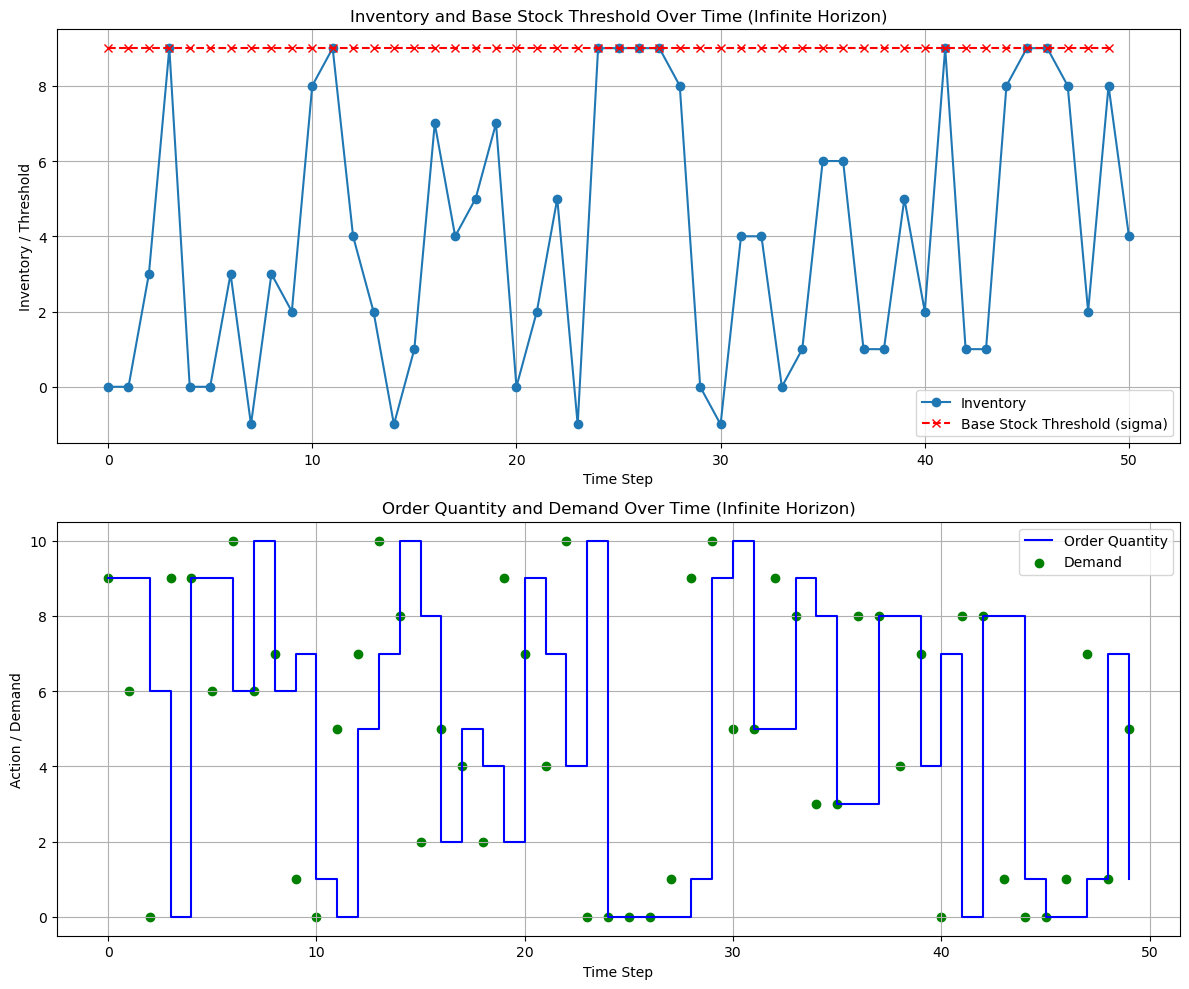

In [13]:
import random
def simulate_and_print_and_plot_infinite(policy, sigma, time_steps):
    """
    Simulate one episode of length time_steps using the stationary infinite-horizon policy.
    Here, the action is taken directly from the stationary policy (policy) derived from pi.
    
    For each time step, print:
      - Current inventory,
      - Base-stock threshold sigma (for reference),
      - Demand,
      - Action (from the policy).
    
    Then, produce two plots:
      1. Inventory vs. time with the constant base-stock threshold line.
      2. Order quantity (action) and demand vs. time.
    """
    current_inventory = 0
    times = []
    inventories = []
    sigma_trace = []
    actions_list = []
    demands = []
    
    print("Time | Inventory |  Base-Stock (sigma) | Demand | Action")
    print("-----------------------------------------------------------")
    for t in range(time_steps):
        state_idx = pi.inv_to_state(current_inventory)
        action = policy[state_idx]  # Use the stationary policy directly.
        demand = random.randint(0, 10)
        print(f"{t:4d} | {current_inventory:9d} | {sigma:18d} | {demand:6d} | {action:6d}")
        
        times.append(t)
        inventories.append(current_inventory)
        sigma_trace.append(sigma)
        actions_list.append(action)
        demands.append(demand)
        
        new_inventory = current_inventory + action - demand
        new_inventory = max(pi.min_inventory, min(new_inventory, pi.max_inventory))
        current_inventory = new_inventory
    
    times.append(time_steps)
    inventories.append(current_inventory)
    
    plt.figure(figsize=(12, 10))
    
    # Subplot 1: Inventory vs. Base-stock threshold (sigma)
    plt.subplot(2, 1, 1)
    plt.plot(times, inventories, marker='o', linestyle='-', label="Inventory")
    plt.plot(range(time_steps), sigma_trace, marker='x', linestyle='--', color='red', label="Base Stock Threshold (sigma)")
    plt.xlabel("Time Step")
    plt.ylabel("Inventory / Threshold")
    plt.title("Inventory and Base Stock Threshold Over Time (Infinite Horizon)")
    plt.legend()
    plt.grid(True)
    
    # Subplot 2: Order Quantity (Action) vs. Demand
    plt.subplot(2, 1, 2)
    plt.step(range(time_steps), actions_list, where='post', label="Order Quantity", color='blue')
    plt.scatter(range(time_steps), demands, label="Demand", color='green')
    plt.xlabel("Time Step")
    plt.ylabel("Action / Demand")
    plt.title("Order Quantity and Demand Over Time (Infinite Horizon)")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

########################################
# Run Simulation for Infinite Horizon
########################################
time_steps_sim = 50
# The stationary policy from infinite-horizon pi is stored in pi_inf.policy (1D array, one per state).
policy_infinite = pi.policy  # Use this policy directly.
simulate_and_print_and_plot_infinite(policy_infinite, sigma, time_steps_sim)

In [15]:
for state in range(min_inv, max_inv+1):
    print(f"State {state}, value = {pi.V[pi.inv_to_state(state)]}")

State -200, value = 1887.8079989560952
State -199, value = 1880.8279989560951
State -198, value = 1874.3934535015496
State -197, value = 1868.5043625924588
State -196, value = 1863.1607262288226
State -195, value = 1858.3625444106406
State -194, value = 1854.1098171379135
State -193, value = 1850.4025444106408
State -192, value = 1847.2407262288225
State -191, value = 1844.6243625924587
State -190, value = 1842.55345350155
State -189, value = 1840.5534535015495
State -188, value = 1838.5534535015495
State -187, value = 1836.5534535015495
State -186, value = 1834.5534535015497
State -185, value = 1832.55345350155
State -184, value = 1830.5534535015495
State -183, value = 1828.5534535015497
State -182, value = 1826.5534535015497
State -181, value = 1824.5534535015497
State -180, value = 1822.5534535015495
State -179, value = 1820.55345350155
State -178, value = 1818.5534535015495
State -177, value = 1816.5534535015495
State -176, value = 1814.5534535015495
State -175, value = 1812.553453